# Outline:



# Introduction & Dataset Overview

Dataset: the dataset consists of a total of 15153 colored radiography images of patients across three conditions: COVID, normal, and pneumonia.


In [6]:
import os
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/COVID-19_Radiography_Dataset.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: /content/dataset/COVID-19_Radiography

In [4]:
import sys
import time
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import zipfile

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

# Exploratory Data Analysis (EDA)


In [7]:
# Extracting all filenames iteratively
base_path = '/content/dataset/COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [8]:
# describe the dataset
#print('number of images for each category:', [len(f) for f in fnames])
print("sample file name: ", fnames[0][0]) #examples of file names

img_counts = pd.DataFrame()
img_counts['category'] = categories
img_counts['count'] = [len(f) for f in fnames]
display(img_counts)

sample file name:  /content/dataset/COVID-19_Radiography_Dataset/COVID/images/COVID-86.png


,category,count
0,COVID/images,3616
1,Normal/images,10192
2,Viral Pneumonia/images,1345


Here we can see that the distribution of number of images for each category is uneven, with most images belonging to the 'normal' category, and the least belonging to the 'pneumonia' category'.

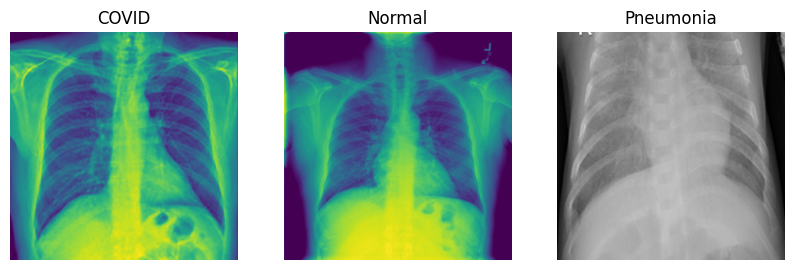

In [9]:
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
import matplotlib.image as mpimg

# Load the image
cvdimg = mpimg.imread(fnames[0][0])
nrmimg = mpimg.imread(fnames[1][0])
pneimg = mpimg.imread(fnames[2][0])

# Display the three sample images

f, axarr = plt.subplots(1, 3, figsize=(10,4))  # 1 row, 3 columns

axarr[0].imshow(cvdimg)
axarr[0].set_title("COVID")

axarr[1].imshow(nrmimg)
axarr[1].set_title("Normal")

axarr[2].imshow(pneimg)
axarr[2].set_title("Pneumonia")

for ax in axarr:
    ax.axis('off')

plt.show()

In [10]:
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single file (imports file and preprocesses it to data with following shape)
preprocessor('/content/dataset/COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

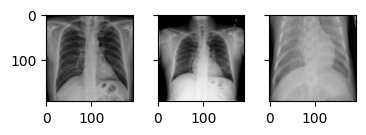

In [11]:
# sample images after preprocessing

im1 =preprocessor(fnames[0][0]) # COVID-positive image
im2 =preprocessor(fnames[1][0]) # normal image
im3 =preprocessor(fnames[2][0]) # viral pneumonia image

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

As our data is heavily imbalanced, with the 'normal' class having almost 8 times more samples than the pneumonia class and about 3 times more than the COVID class, we would need to rebalance the dataset.
We can conduct undersampling to have the sample number match the smallest class, but that way we would lose valuable data and our model would also have weaker generalizability. For similar reasons we would also want to avoid oversampling, which simply duplicates new samples from our smallest class and can result in the model overfitting. A better approach would be to apply data augmentation on the smallest class, while also calculating class weights by assigning higher loss weights to the minority classes during training, which is especially effective in training neural networks.


However, due to limitation of computing power, we will use the undersampling technique.



In [12]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [13]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [14]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [15]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
4027,False,False,True
4028,False,False,True
4029,False,False,True
4030,False,False,True


In [16]:
# Train test split resized images
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [17]:
import pickle

# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

To explore which factors may be related to the classification of the three conditions, we tried comparing the average brightness images across each category.

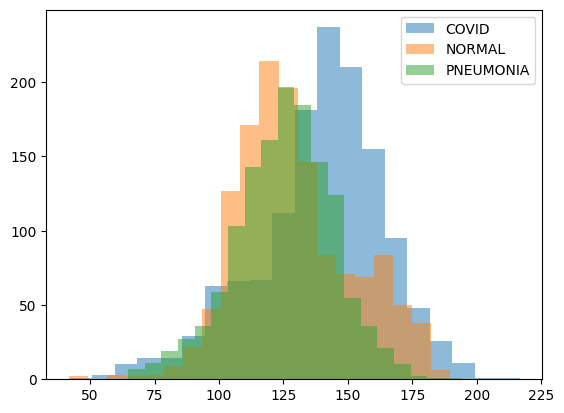

In [19]:
# plot distribution of brightness of images in each category

from PIL import ImageStat

# define image brightness function that converts images to greyscale

def brightness(im_file):
  im = Image.open(im_file).convert('L')
  stat = ImageStat.Stat(im)
  return stat.mean[0]

# iterate through data

covid_brightness=list(map(brightness, fnames[0]))
normal_brightness=list(map(brightness, fnames[1]))
pneumonia_brightness=list(map(brightness, fnames[2]))

# plot distribution of brightness

plt.hist(covid_brightness, bins=20, alpha=0.5, label='COVID')
plt.hist(normal_brightness, bins=20, alpha=0.5, label='NORMAL')
plt.hist(pneumonia_brightness, bins=20, alpha=0.5, label='PNEUMONIA')
plt.legend(loc='upper right')


It can be seen from the histogram that while the average brightness for "normal"-labeled images is normally distributed around 125, the distribution of "covid"-labeled images is skewed left, and the distributino of "pneumonia"-labeled images is skewed right. To test this, we calculated the mean and sd for each category, and then conducted a one-way ANOVA to see if there is a significant differece across three groups.

In [20]:
print("covid image average brightness: ", np.mean(covid_brightness), "standard deviation: ", np.std(covid_brightness))
print("normal image average brightness: ", np.mean(normal_brightness), "standard deviation: ", np.std(normal_brightness))
print("pneumonia image average brightness: ", np.mean(pneumonia_brightness), "standard deviation: ", np.std(pneumonia_brightness))

covid image average brightness:  139.31161798885282 standard deviation:  24.952228993894465
normal image average brightness:  129.38330438571052 standard deviation:  22.525238517043714
pneumonia image average brightness:  125.35535370063508 standard deviation:  18.973751385912003


In [21]:
# conduct ANOVA for three averages

from scipy.stats import f_oneway

f_statistic, p_value = f_oneway(covid_brightness, normal_brightness, pneumonia_brightness)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")


F-statistic: 139.51535387861784
P-value: 2.6017891328751414e-59


Based on the ANOVA, it can be seen that the average brightness is significantly different across the three types of radiography images.

Through modeling, we can more accurately classify radiography images to match their respective conditions. This is extremely helpful to support clinical descisions through a quicker identification of potential critical conditions that require more urgent attention. It can serve as a powerful screening tool for clinics where radiologists may be understaffed. Analyzing and identifying feature importance in these models can also improve understanding on potentially important biomarkers in these diseases.

# Baseline CNN Model



This baseline CNN consists of:
- 3 Convolutional blocks (Conv2D + MaxPooling + Dropout)
- Fully connected layers for classification
- Total of ~1.8M parameters

Architecture choices:
- ReLU activation for non-linearity
- MaxPooling for downsampling
- Dropout for regularization to prevent overfitting
- Softmax output for multi-class classification

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

**Build Baseline CNN Architecture**

In [23]:
def create_baseline_cnn(input_shape=(192, 192, 3), num_classes=3):
    """
    Create a baseline CNN architecture for medical image classification.

    Parameters:
    - input_shape: tuple, shape of input images (height, width, channels)
    - num_classes: int, number of output classes

    Returns:
    - model: compiled Keras model
    """

    model = Sequential(name='Baseline_CNN')

    # First Convolutional Block
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                     padding='same', input_shape=input_shape, name='conv1'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))
    model.add(Dropout(0.25, name='dropout1'))

    # Second Convolutional Block
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',
                     padding='same', name='conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool2'))
    model.add(Dropout(0.25, name='dropout2'))

    # Third Convolutional Block
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',
                     padding='same', name='conv3'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool3'))
    model.add(Dropout(0.25, name='dropout3'))

    # Flatten and Fully Connected Layers
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dropout(0.5, name='dropout4'))
    model.add(Dense(num_classes, activation='softmax', name='output'))

    return model

In [24]:
# Create the model
baseline_cnn = create_baseline_cnn(input_shape=(192, 192, 3), num_classes=3)

# Display model architecture
baseline_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 192, 192, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 96, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,968,643 (72.36 MB)

 Trainable params: 18,968,643 (72.36 MB)

 Non-trainable params: 0 (0.00 B)

**Compile and Configure Training**

Model Configuration:
- Loss Function: categorical_crossentropy (for multi-class classification)
- Optimizer: Adam （learning rate of 0.001）
- Metrics: accuracy for performance evaluation

Callbacks:
- EarlyStopping: stops training if validation loss doesn't improve for 5 epochs
- ReduceLROnPlateau: reduces learning rate when validation loss plateaus

In [25]:
# Compile the model
baseline_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks for training
callbacks_baseline = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

**Train the Baseline CNN**

Training Configuration:
- Epochs: 10 (with early stopping)
- Batch size: 32
- Validation split: 20% of training data

In [29]:
history_baseline = baseline_cnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=callbacks_baseline,
    verbose=1
)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.4879 - loss: 1.6664 - val_accuracy: 0.7905 - val_loss: 0.4689 - learning_rate: 0.0010
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7737 - loss: 0.4858 - val_accuracy: 0.8616 - val_loss: 0.3592 - learning_rate: 0.0010
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8484 - loss: 0.3511 - val_accuracy: 0.8798 - val_loss: 0.3166 - learning_rate: 0.0010
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.8858 - loss: 0.2799 - val_accuracy: 0.8998 - val_loss: 0.2612 - learning_rate: 0.0010
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8990 - loss: 0.2416 - val_accuracy: 0.9053 - val_loss: 0.2453 - learning_rate: 0.0010
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9288 - loss: 0.1901 - val_accuracy: 0.9162 - val_loss: 0.2256 - learning_rate: 0.0010
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9448 - loss: 0.1469 - val_acc

**Evaluate Baseline CNN Performance**

In [35]:
test_loss_baseline, test_acc_baseline = baseline_cnn.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss:     {test_loss_baseline:.4f}")
print(f"Test Accuracy: {test_acc_baseline:.4f} ({test_acc_baseline*100:.2f}%)")

final_train_acc = history_baseline.history['accuracy'][-1]
final_val_acc = history_baseline.history['val_accuracy'][-1]

print(f"\nFinal Training Accuracy:   {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

Test Loss:     1.1024
Test Accuracy: 0.3765 (37.65%)


NameError: name 'history_baseline' is not defined

**Visualize Training History**

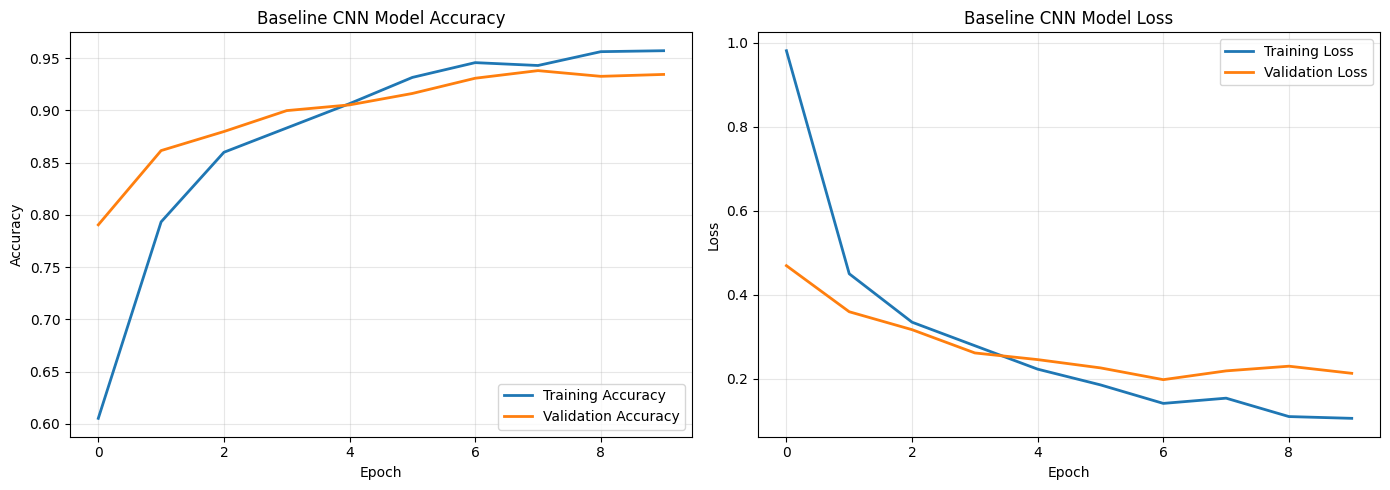


Training Summary:
Total epochs trained: 10
Best validation accuracy: 0.9381
Best validation loss: 0.1976


In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training & validation accuracy
axes[0].plot(history_baseline.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history_baseline.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Baseline CNN Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Training & validation loss
axes[1].plot(history_baseline.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history_baseline.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Baseline CNN Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTraining Summary:")
print(f"Total epochs trained: {len(history_baseline.history['loss'])}")
print(f"Best validation accuracy: {max(history_baseline.history['val_accuracy']):.4f}")
print(f"Best validation loss: {min(history_baseline.history['val_loss']):.4f}")

# Transfer Learning with ResNet

Transfer Learning:
1. Load ResNet50 pre-trained on ImageNet
2. Freeze the base convolutional layers (feature extractor)
3. Add custom classification layers
4. Fine-tune (maybe)


In [32]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [33]:
def create_resnet_transfer_model(input_shape=(192, 192, 3), num_classes=3, trainable_base=False):
    """
    Create ResNet50 model with transfer learning.

    Parameters:
    - input_shape: tuple, shape of input images
    - num_classes: int, number of output classes
    - trainable_base: bool, whether to fine-tune base layers

    Returns:
    - model: compiled Keras model
    """

    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    base_model.trainable = trainable_base

    x = base_model.output
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='dropout1')(x)
    x = Dense(128, activation='relu', name='fc2')(x)
    x = Dropout(0.3, name='dropout2')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=base_model.input, outputs=outputs, name='ResNet50_Transfer')

    return model, base_model

In [34]:
# Create ResNet50 transfer learning model
resnet_model, resnet_base = create_resnet_transfer_model(
    input_shape=(192, 192, 3),
    num_classes=3,
    trainable_base=False
)

resnet_model.summary()

Model: "ResNet50_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 192, 192,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 198, 198,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 96, 96,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 96, 96,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 96, 96,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 98, 98,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 48, 48,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 48, 48,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 48, 48,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 48, 48,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 48, 48,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 48, 48,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 48, 48,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 48, 48,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 48, 48,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 48, 48,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 48, 48,    │      1,024 │ conv2_block1_3_c

 Total params: 24,145,539 (92.11 MB)

 Trainable params: 557,827 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**Preprocess Data for ResNet**

ResNet50 requires specific preprocessing:
- Input images should be in range [0, 255]
- Apply ImageNet preprocessing (mean subtraction and scaling)

Our data is currently in [0, 1], so we need to scale it back.

In [35]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

X_train_resnet = resnet_preprocess((np.copy(X_train) * 255.0).astype('float32'))
X_test_resnet = resnet_preprocess((np.copy(X_test) * 255.0).astype('float32'))

print(f"Training data shape: {X_train_resnet.shape}")
print(f"Test data shape: {X_test_resnet.shape}")
print(f"Training data range: [{X_train_resnet.min():.2f}, {X_train_resnet.max():.2f}]")

Training data shape: (2741, 192, 192, 3)
Test data shape: (1291, 192, 192, 3)
Training data range: [-124.68, 151.06]


**Compile and Train ResNet Model**

Training Configuration for ResNet:
- Lower learning rate (0.0001)
- Same callbacks as baseline for fair comparison

In [36]:
resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_resnet = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    )
]

In [37]:
history_resnet = resnet_model.fit(
    X_train_resnet, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=callbacks_resnet,
    verbose=1
)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.4882 - loss: 1.1949 - val_accuracy: 0.8579 - val_loss: 0.4295 - learning_rate: 1.0000e-04
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 293s 4s/step - accuracy: 0.7556 - loss: 0.5604 - val_accuracy: 0.8816 - val_loss: 0.3319 - learning_rate: 1.0000e-04
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.8109 - loss: 0.4355 - val_accuracy: 0.8725 - val_loss: 0.2990 - learning_rate: 1.0000e-04
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.8513 - loss: 0.3658 - val_accuracy: 0.8852 - val_loss: 0.2807 - learning_rate: 1.0000e-04
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.8687 - loss: 0.3231 - val_accuracy: 0.8852 - val_loss: 0.2593 - learning_rate: 1.0000e-04
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.8620 - loss: 0.3145 - val_accuracy: 0.8907 - val_loss: 0.2529 - learning_rate: 1.0000e-04
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.8994 

**Evaluate ResNet Performance**

In [38]:
test_loss_resnet, test_acc_resnet = resnet_model.evaluate(X_test_resnet, y_test, verbose=0)

print(f"Test Loss:     {test_loss_resnet:.4f}")
print(f"Test Accuracy: {test_acc_resnet:.4f} ({test_acc_resnet*100:.2f}%)")

final_train_acc_resnet = history_resnet.history['accuracy'][-1]
final_val_acc_resnet = history_resnet.history['val_accuracy'][-1]

print(f"\nFinal Training Accuracy:   {final_train_acc_resnet:.4f} ({final_train_acc_resnet*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc_resnet:.4f} ({final_val_acc_resnet*100:.2f}%)")

Test Loss:     0.6451
Test Accuracy: 0.8908 (89.08%)

Final Training Accuracy:   0.9211 (92.11%)
Final Validation Accuracy: 0.9035 (90.35%)


**Visualize ResNet Training History**

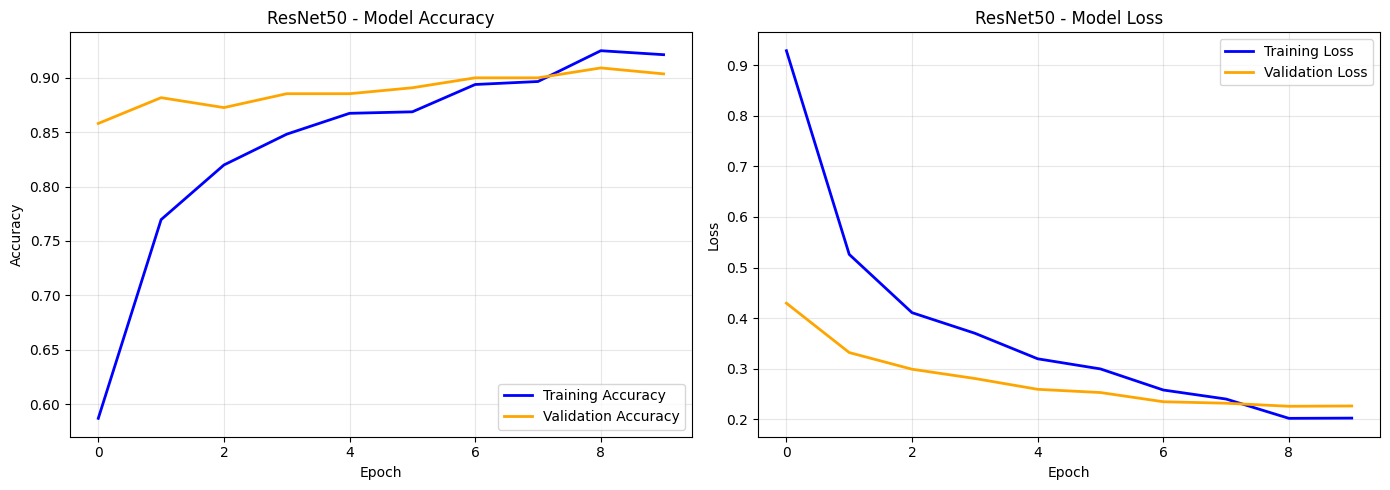

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training & validation accuracy
axes[0].plot(history_resnet.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
axes[0].plot(history_resnet.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
axes[0].set_title('ResNet50 - Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Training & validation loss
axes[1].plot(history_resnet.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[1].plot(history_resnet.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[1].set_title('ResNet50 - Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Data Augmentation**

For medical images (chest X-rays), we use CONSERVATIVE augmentation:
- ±5 degrees small rotations to account for patient positioning
- ±5% small shifts for horizontal and vertical translations
- 95%-105% small zoom to simulate distance variations
- NO horizontal/vertical flips
- NO heavy distortions

This increases dataset size and improves model generalization without
compromising the clinical validity of the images.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Define augmentation parameters for medical images
medical_augmentation = ImageDataGenerator(
    rotation_range=5,           # Small rotation (±5 degrees)
    width_shift_range=0.05,     # Horizontal shift (±5%)
    height_shift_range=0.05,    # Vertical shift (±5%)
    zoom_range=0.05,            # Zoom in/out (95%-105%)
    horizontal_flip=False,      # NO flip
    vertical_flip=False,        # NO vertical flip
    fill_mode='nearest',        # Fill empty pixels with nearest values
    validation_split=0.2        # 20% for validation
)

test_datagen = ImageDataGenerator()

**Visualize Augmented Samples**

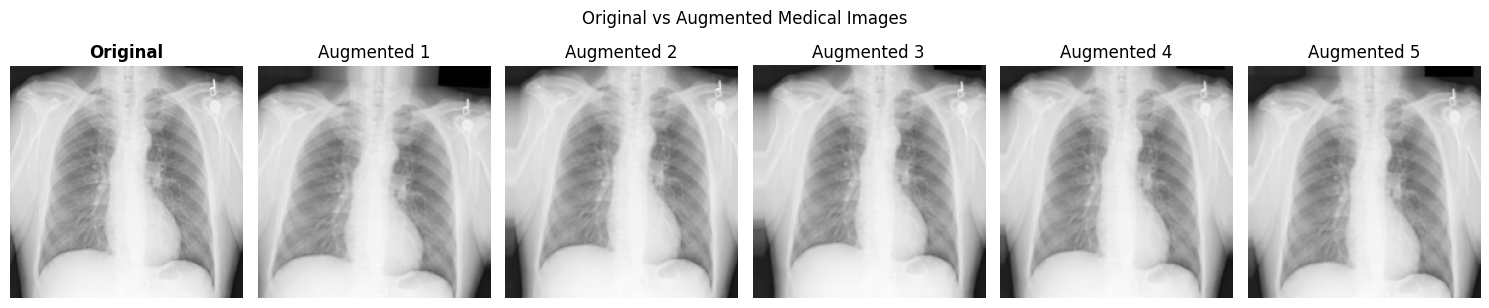

In [26]:
vis_augmentation = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

sample_image = X_train[0:1]

plt.figure(figsize=(15, 3))

# Original image
plt.subplot(1, 6, 1)
plt.imshow(sample_image[0])
plt.title('Original', fontweight='bold')
plt.axis('off')

# Generate 5 augmented versions
for i in range(5):
    aug_iter = vis_augmentation.flow(sample_image, batch_size=1)
    aug_image = next(aug_iter)[0]

    plt.subplot(1, 6, i+2)
    plt.imshow(aug_image)
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.suptitle('Original vs Augmented Medical Images', y=1.02)
plt.tight_layout()
plt.show()

**Create CNN Model with Augmentation**

In [27]:
def create_baseline_cnn_augmented(input_shape=(192, 192, 3), num_classes=3):
    """
    Same CNN architecture to baseline model.
    The only difference will be training with augmented data.
    """

    model = Sequential(name='Baseline_CNN_Augmented')

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                     padding='same', input_shape=input_shape, name='conv1'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))
    model.add(Dropout(0.25, name='dropout1'))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',
                     padding='same', name='conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool2'))
    model.add(Dropout(0.25, name='dropout2'))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',
                     padding='same', name='conv3'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool3'))
    model.add(Dropout(0.25, name='dropout3'))

    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dropout(0.5, name='dropout4'))
    model.add(Dense(num_classes, activation='softmax', name='output'))

    return model

In [28]:
cnn_augmented = create_baseline_cnn_augmented(input_shape=(192, 192, 3), num_classes=3)

In [29]:
cnn_augmented.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_augmented.summary()

Model: "Baseline_CNN_Augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 192, 192, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 96, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,968,643 (72.36 MB)

 Trainable params: 18,968,643 (72.36 MB)

 Non-trainable params: 0 (0.00 B)

**Train CNN with Augmented Data**

In [31]:
callbacks_augmented = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

history_cnn_augmented = cnn_augmented.fit(
    medical_augmentation.flow(X_train, y_train, batch_size=32, subset='training'),
    validation_data=medical_augmentation.flow(X_train, y_train, batch_size=32, subset='validation'),
    epochs=10,
    callbacks=callbacks_augmented,
    verbose=1
)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.5623 - loss: 1.6096 - val_accuracy: 0.7318 - val_loss: 0.5827 - learning_rate: 0.0010
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.7274 - loss: 0.5213 - val_accuracy: 0.7245 - val_loss: 0.5248 - learning_rate: 0.0010
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - accuracy: 0.7694 - loss: 0.4888 - val_accuracy: 0.7682 - val_loss: 0.5151 - learning_rate: 0.0010
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.7874 - loss: 0.4627 - val_accuracy: 0.7901 - val_loss: 0.4830 - learning_rate: 0.0010
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.7939 - loss: 0.3998 - val_accuracy: 0.8266 - val_loss: 0.4407 - learning_rate: 0.0010
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.8389 - loss: 0.3705 - val_accuracy: 0.8230 - val_loss: 0.4078 - learning_rate: 0.0010
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.8305 - loss: 0.4087 - val_acc

**Evaluate CNN with Augmentation**

In [32]:
test_loss_augmented, test_acc_augmented = cnn_augmented.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss:     {test_loss_augmented:.4f}")
print(f"Test Accuracy: {test_acc_augmented:.4f} ({test_acc_augmented*100:.2f}%)")

final_train_acc_aug = history_cnn_augmented.history['accuracy'][-1]
final_val_acc_aug = history_cnn_augmented.history['val_accuracy'][-1]

print(f"\nFinal Training Accuracy:   {final_train_acc_aug:.4f} ({final_train_acc_aug*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc_aug:.4f} ({final_val_acc_aug*100:.2f}%)")

Test Loss:     0.6664
Test Accuracy: 0.8304 (83.04%)

Final Training Accuracy:   0.8682 (86.82%)
Final Validation Accuracy: 0.8595 (85.95%)


**Visualize Augmented CNN Training History**

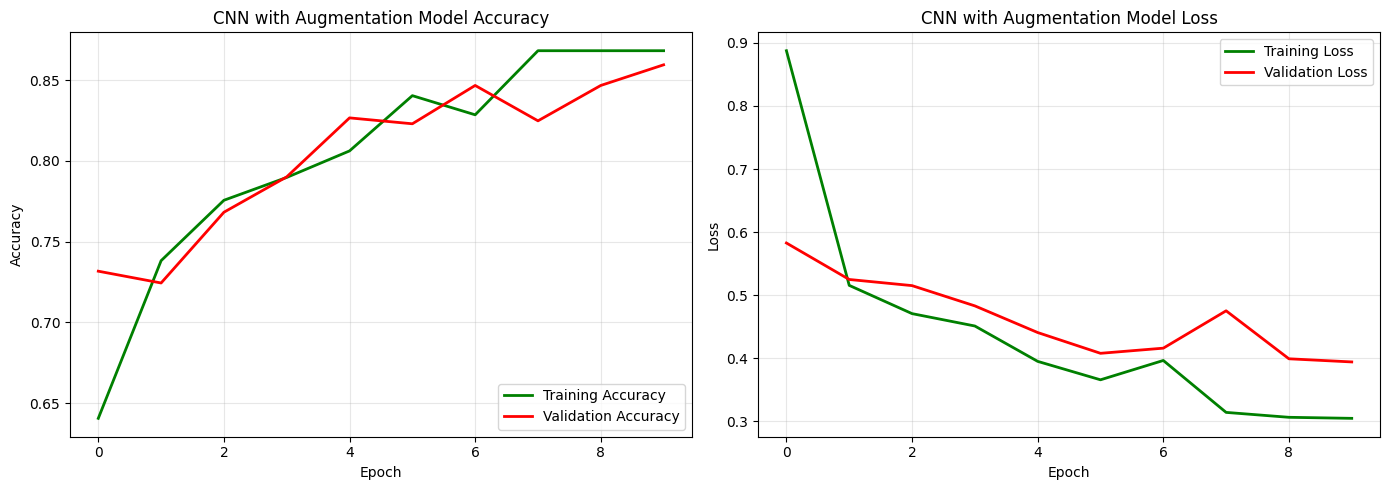

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training & validation accuracy
axes[0].plot(history_cnn_augmented.history['accuracy'], label='Training Accuracy', linewidth=2, color='green')
axes[0].plot(history_cnn_augmented.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
axes[0].set_title('CNN with Augmentation Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Training & validation loss
axes[1].plot(history_cnn_augmented.history['loss'], label='Training Loss', linewidth=2, color='green')
axes[1].plot(history_cnn_augmented.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
axes[1].set_title('CNN with Augmentation Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Compare All Three Models**

In [34]:
comparison_all_models = pd.DataFrame({
    'Model': ['Baseline CNN (No Aug)', 'Baseline CNN (With Aug)', 'ResNet50 Transfer Learning'],
    'Test Accuracy': [test_acc_baseline, test_acc_augmented, test_acc_resnet],
    'Test Loss': [test_loss_baseline, test_loss_augmented, test_loss_resnet],
    'Final Train Acc': [final_train_acc, final_train_acc_aug, final_train_acc_resnet],
    'Final Val Acc': [final_val_acc, final_val_acc_aug, final_val_acc_resnet],
    'Epochs Trained': [
        len(history_baseline.history['loss']),
        len(history_cnn_augmented.history['loss']),
        len(history_resnet.history['loss'])
    ],
    'Data Augmentation': ['No', 'Yes', 'No'],
    'Transfer Learning': ['No', 'No', 'Yes']
})

display(comparison_all_models)

# Highlight the best model
best_model_idx = comparison_all_models['Test Accuracy'].idxmax()
best_model_name = comparison_all_models.loc[best_model_idx, 'Model']
best_test_acc = comparison_all_models.loc[best_model_idx, 'Test Accuracy']

print(f" BEST PERFORMING MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_test_acc:.4f} ({best_test_acc*100:.2f}%)")

aug_improvement = test_acc_augmented - test_acc_baseline
aug_improvement_pct = (aug_improvement / test_acc_baseline) * 100

print(f"\n IMPACT OF DATA AUGMENTATION:")
if aug_improvement > 0:
    print(f"    Data augmentation improved performance by {aug_improvement:.4f} ({aug_improvement_pct:.2f}%)")
else:
    print(f"    Baseline performed {abs(aug_improvement):.4f} better")

NameError: name 'test_acc_baseline' is not defined

**Compare Baseline CNN vs ResNet50 vs CNN (with augumentation)**



In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(history_baseline.history['accuracy'], label='Train', linewidth=2, alpha=0.8)
axes[0, 0].plot(history_baseline.history['val_accuracy'], label='Val', linewidth=2, alpha=0.8)
axes[0, 0].set_title('Baseline CNN (No Aug)\nAccuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_cnn_augmented.history['accuracy'], label='Train', linewidth=2, alpha=0.8, color='green')
axes[0, 1].plot(history_cnn_augmented.history['val_accuracy'], label='Val', linewidth=2, alpha=0.8, color='red')
axes[0, 1].set_title('Baseline CNN (With Aug)\nAccuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(history_resnet.history['accuracy'], label='Train', linewidth=2, alpha=0.8, color='blue')
axes[0, 2].plot(history_resnet.history['val_accuracy'], label='Val', linewidth=2, alpha=0.8, color='orange')
axes[0, 2].set_title('ResNet50 Transfer\nAccuracy')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Row 2: Loss plots
axes[1, 0].plot(history_baseline.history['loss'], label='Train', linewidth=2, alpha=0.8)
axes[1, 0].plot(history_baseline.history['val_loss'], label='Val', linewidth=2, alpha=0.8)
axes[1, 0].set_title('Baseline CNN (No Aug)\nLoss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history_cnn_augmented.history['loss'], label='Train', linewidth=2, alpha=0.8, color='green')
axes[1, 1].plot(history_cnn_augmented.history['val_loss'], label='Val', linewidth=2, alpha=0.8, color='red')
axes[1, 1].set_title('Baseline CNN (With Aug)\nLoss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(history_resnet.history['loss'], label='Train', linewidth=2, alpha=0.8, color='blue')
axes[1, 2].plot(history_resnet.history['val_loss'], label='Val', linewidth=2, alpha=0.8, color='orange')
axes[1, 2].set_title('ResNet50 Transfer\nLoss')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('Training Curves Comparison: All Three Models', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Additional Architectures (3 models)



# Data Augmentation Experiment



# Model Comparison & Evaluation



# Interpretability & Conclusions